# Spectrogram classification 모델 구현

## 1. Wave data 받기
waveform 형태의 데이터를 [여기](https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz)에서 다운로드한다.   데이터셋은 [캐글의 음성인식 챌린지의 데이터](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)이다.
이제 다운로드한 데이터를 연다.

In [1]:
# 데이터 열기
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


데이터를 랜덤하게 선택하여 확인해 본다.

In [2]:
# 데이터 확인
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 볼 것)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  189
Wave data shape :  (8000,)
label :  ['down']


## 2. Spectrogram 데이터로 변환

파이썬에서 제공하는 FFT 관련 라이브러리인 librosa를 설치한 후, 변환 함수를 만든다.

In [3]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


1차원의 Waveform 데이터를 2차원의 Spectrogram 데이터로 변환한다. Spectrogram이란 wav 데이터를 해석하는 방법 중 하나로, 일정 시간동안 wav 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는 지를 보여준다. 

In [4]:
spec = []
for wav in speech_data["wav_vals"]:
    spec.append(wav2spec(wav))
spec = np.array(spec)

In [5]:
print(spec)

[[[8.07239022e-03 5.20321820e-03 3.46932188e-03 ... 1.89226624e-02
   3.38094338e-04 1.01425797e-02]
  [6.54867850e-03 3.28520965e-03 2.24959152e-03 ... 2.55274866e-02
   1.65257771e-02 3.23262019e-03]
  [2.42263544e-03 3.50804720e-03 2.47263722e-03 ... 2.79524736e-02
   2.66932826e-02 1.76283494e-02]
  ...
  [5.82929701e-04 2.90359138e-04 1.41317860e-05 ... 6.02452528e-05
   3.13075114e-04 5.09336183e-04]
  [5.24342293e-04 2.58603919e-04 1.29954742e-05 ... 2.12755695e-05
   2.22929710e-04 4.76511224e-04]
  [5.14480518e-04 2.59085355e-04 1.65004258e-06 ... 5.26433269e-06
   2.32991573e-04 4.38952440e-04]]

 [[6.09248221e-01 6.71129882e-01 6.83828115e-01 ... 7.37418592e-01
   7.17465222e-01 7.17303455e-01]
  [2.49074861e-01 3.70635331e-01 3.60249221e-01 ... 3.50217849e-01
   3.70684743e-01 3.44797850e-01]
  [6.30091578e-02 7.02991635e-02 4.94679362e-02 ... 3.67690660e-02
   3.18726189e-02 3.49331424e-02]
  ...
  [4.38341312e-03 2.24552257e-03 1.75364723e-04 ... 1.63672739e-04
   1.53791

In [6]:
# 위에서 뽑았던 sample data
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (50620, 130, 126)


Spectrogram을 그리는 방법이 STFT(Short Time Fourier Transform)이다. X축은 시간, Y축은 주파수를 나타내며, 해당 시간/주파수에서의 음파 강도에 따라 밝은색으로 표현된다. wav 데이터가 단위 시간만큼 Short Time Fourier Transform을 진행해 매 순간의 주파수 데이터들을 얻어서 Spectrogram을 완성한다. 2차원의 데이터이므로 1차원씩 그래프를 그려보면 아래와 같다.

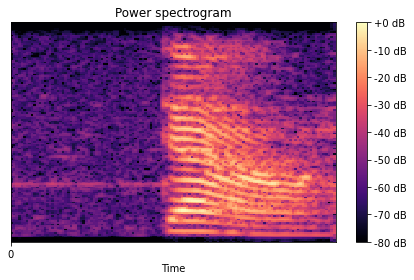

In [7]:
# Spectrogram 출력
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec[2], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

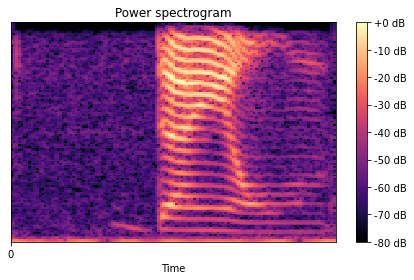

In [8]:
# Spectrogram 출력
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec[1], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 3. 데이터의 처리와 분류

### 1) 라벨 데이터 처리

학습을 위해서는 Text 데이터를 학습가능한 형태로 만들어줘야 한다. Text로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업을 한다. int로 이뤄진 index 작업을 통해서 Label data를 더 쉽게 사용할 수 있다. 

In [7]:
# Label data 처리
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

# 라벨값을 딕셔너리로 저장
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [8]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

### 2) 학습을 위한 데이터 분리
sklearn의 train_test_split 함수를 이용해 train data와 test data를 분리한다. (test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정할 수 있다.)

In [11]:
xr = spec.shape[1]
yr = spec.shape[2]
print(xr)
print(yr)

130
126


In [9]:
# train data/test data separated

from sklearn.model_selection import train_test_split
# test_size의 인자 조절 가능
xr = spec.shape[1]
yr = spec.shape[2]
train_wav, test_wav, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,  
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, xr, yr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, xr, yr, 1])
print("✅")

[[[2.66658748e-03 1.81869126e-03 1.61420117e-04 ... 3.62323015e-04
   2.25493670e-04 1.18351076e-03]
  [3.32372333e-03 6.95107970e-04 1.43144594e-03 ... 9.00468847e-04
   1.00528460e-03 1.24153856e-03]
  [4.71856957e-03 4.35093744e-03 4.50763805e-03 ... 4.43214056e-04
   1.46730652e-03 5.58514032e-04]
  ...
  [1.00264663e-03 8.42490641e-04 5.29950135e-04 ... 1.02114509e-05
   1.31532448e-04 2.49218720e-04]
  [4.76145739e-04 1.22993602e-04 8.24356030e-05 ... 1.61273438e-05
   1.35352821e-04 2.54635117e-04]
  [2.84888898e-04 9.11364623e-05 1.09257699e-05 ... 3.97697295e-06
   1.19470897e-04 2.41713031e-04]]

 [[3.02862786e-02 1.88882053e-02 3.53509709e-02 ... 6.57272618e-03
   1.11059817e-02 4.38574981e-03]
  [7.05989301e-02 6.67285696e-02 4.05420437e-02 ... 1.44379921e-02
   2.63849664e-02 1.81450918e-02]
  [5.75350001e-02 8.01714584e-02 4.56943139e-02 ... 5.68294851e-03
   4.01980802e-02 6.88050091e-02]
  ...
  [6.65496988e-03 2.95162294e-03 5.22682094e-04 ... 5.36577078e-04
   2.52436

나누어진 데이터셋을 확인한다.

In [10]:
# 데이터셋 확인
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)
✅


## 4. 학습을 위한 Hyper-parameters setting
학습을 위한 하이퍼파라미터를 설정하고 모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해준다.후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용한다.

> [체크포인트](http://jaynewho.com/post/8)       
Checkpoint 은 학습된 모델의 Variable 값을 저장하는 파일이다. Checkpoint 파일을 저장하고 불러옴으로써 학습된 모델을 재사용하고, 지난 학습을 이어서 더 하고 하는 작업들이 가능해진다.

In [11]:
# Hyper-parameters setting
batch_size = 32
max_epochs = 10

# save model  check point
# 체크포인트의 경로 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj44/aiffel/speech_recognition/models/wav'

## 5. 데이터셋 구성
tf.data.Dataset을 이용하여 데이터셋을 구성한다. 
from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있다. 
### 1) map함수에 넘겨줄 데이터 전처리 함수      
map 함수는 dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할을 한다. 첫번째 map 함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정한다. 또한 map 함수는 중첩해서 사용이 가능하다.

In [12]:
# map함수에 넘겨줄 데이터 전처리 함수
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


### 2) tf.data.Dataset 함수 구성      
batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수이다. 

주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있다. tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 된다.
```
del speech_data     
del spec_data
```

In [13]:
# tf.data.Dataset 함수를 구성
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


## 6. 2차원 Spectrogram 데이터를 처리하는 모델 구성(Conv2D layer)

### 1) Model
Spectrogram 데이터는 2차원이므로 Spectrogram 데이터의 시간축 방향으로 Conv2D layer를 이용해서 모델을 구성해보았다. Conv, batch norm, dropout, dense layer 등을 이용해 모델을 구성했다.

In [17]:
# 모델 구성
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(xr, yr, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

### 2) Loss
현재 라벨이 될 수 있는 12개의 단어 class를 구분하기 위해서는 multi-class classification이 필요하며, 이를 수행하기 위한 Loss로 Categorical Cross-Entropy loss를 사용한다. optimizer로 Adam optimizer를 사용하였다. 

In [18]:
# loss 
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


### 3) Training
- Callback함수     
model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있다.

모델을 재사용하기 위해서 모델 가중치를 저장하는 checkpoint callback 함수를 추가하였다. Model Checkpoint callback은 모델을 학습을 진행하며, fit 함수내 다양한 인자를 지정해 모니터하며 동작하게 설정할 수 있다. 현재 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있다.

In [19]:
del speech_data
del spec

In [20]:
# call back: 모델 재사용을 위한 모델 가중치 저장
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


아래는 모델 학습 코드이다.      
주의: 메모리 사용량에 주의하며 적절히 하이퍼파라미터 세팅을 조절해야 한다. 메모리가 부족하다면 batch_size를 작게 조절해 주는게 좋다.

In [21]:
# 모델 학습 코드
# 30분 내외 소요 
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.7792
Epoch 00001: val_loss improved from inf to 0.28007, saving model to /home/aiffel-dj44/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 199s 140ms/step - loss: 0.6646 - accuracy: 0.7792 - val_loss: 0.2801 - val_accuracy: 0.9092
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9265
Epoch 00002: val_loss improved from 0.28007 to 0.21377, saving model to /home/aiffel-dj44/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 200s 140ms/step - loss: 0.2326 - accuracy: 0.9265 - val_loss: 0.2138 - val_accuracy: 0.9333
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.9470
Epoch 00003: val_loss improved from 0.21377 to 0.17935, saving model to /home/aiffel-dj44/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 200s 141ms

## 7-1. 학습 결과를 그래프로 출력
model.fit 함수는 학습 동안의 결과를 return해 준다. return 값을 기반으로 loss와 accuracy를 그래프로 표현하였다.
fit 함수에서 전달 받은 Loss와 Accuracy의 값을 이용해 모델이 어떻게 학습되고 있는지 볼 수 있고, 출력된 그래프를 기반으로 모델의 학습이 어떻게 진행됐는지 확인해볼 수 있다.

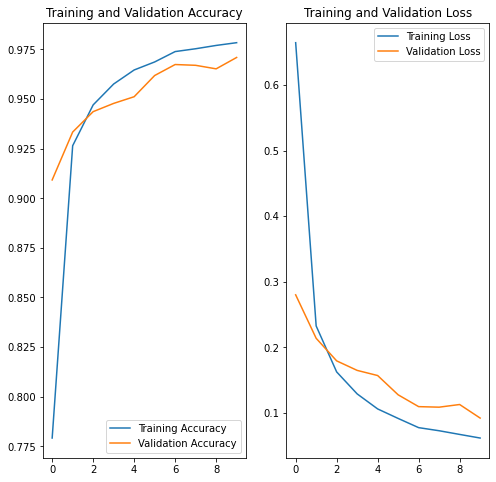

✅


In [22]:
# 학습 결과를 기반으로 loss, accuracy 그래프 그리기

import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하고 있다.

## 8-1. 테스트 데이터셋을 이용해 모델의 성능 평가

Test dataset을 이용해서 모델의 성능을 평가할 수 있다. checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트 준비를 하고, Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인하였다. 

In [23]:
# 성능 평가 준비
model_wav.load_weights(checkpoint_dir)
print("✅")

# 예측값과 실제값 일치 확인
results = model_wav.evaluate(test_dataset)
print("✅")

✅
159/159 [==============================] - 30s 187ms/step - loss: 0.0920 - accuracy: 0.9710
✅


In [24]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.092
accuracy value: 97.0960%
✅


### Model Test
Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인하였다. 

In [25]:
# test data를 골라 모델의 예측이 맞는지 확인
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(xr*yr,), rate=xr*yr)

label :  down


위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction 결과를 비교하였다.

In [26]:
# test data의 라벨과 모델의 실제 예측 결과 비교
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: down(Correct!)
✅


## 6-2. Skip-Connection model
기존의 모델을 skip-connection이 추가된 모델로 변경하였다. Concat을 이용하여 위쪽의 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현된다.

In [14]:
del speech_data
del spec

### 1) Model

In [15]:
# Skip-Connection model
from tensorflow.keras import layers
input_tensor = layers.Input(shape=(xr, yr, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)   # Concat 이용, -1은 axis
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 2624        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 82976       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### 2) Loss

In [16]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


### 3) Training

In [17]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [18]:
# Hyper-parameters setting
batch_size = 32
max_epochs = 7


# 모델 학습
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/7
1423/1423 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.7731
Epoch 00001: val_loss improved from inf to 0.26037, saving model to /home/aiffel-dj44/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 218s 153ms/step - loss: 0.7009 - accuracy: 0.7731 - val_loss: 0.2604 - val_accuracy: 0.9142
Epoch 2/7
1423/1423 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9329
Epoch 00002: val_loss improved from 0.26037 to 0.16624, saving model to /home/aiffel-dj44/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 231s 162ms/step - loss: 0.2081 - accuracy: 0.9329 - val_loss: 0.1662 - val_accuracy: 0.9458
Epoch 3/7
1423/1423 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9555
Epoch 00003: val_loss did not improve from 0.16624
1423/1423 [==============================] - 245s 172ms/step - loss: 0.1370 - accuracy: 0.9555 - val_loss: 0.1986 - val_accu

### 학습결과 시각화

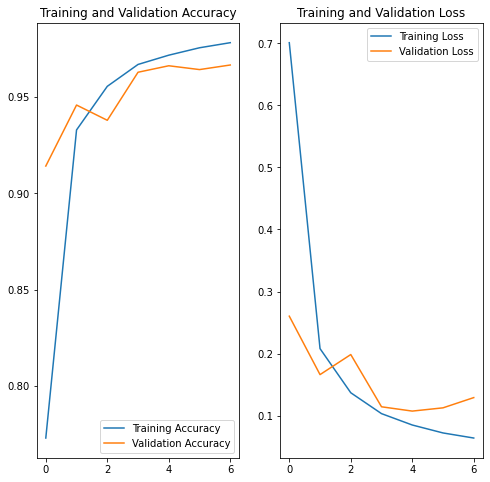

✅


In [19]:
# 학습 결과 시각화
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

epochs=7일 때, 스펙트로그램을 입력받은 skip-connection model의 accuracy는 안정적으로 수렴하나, loss는 epochs=4가 넘어가자 발산하는 듯한 모습을 보인다.

In [20]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

159/159 [==============================] - 28s 174ms/step - loss: 0.1074 - accuracy: 0.9662
loss value: 0.107
accuracy value: 96.6219%
✅


### 모델 테스트

In [21]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(xr*yr,), rate=xr*yr)

label :  go


In [22]:
# 테스트셋의 라벨과 모델의 실제 예측 결과 비교
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: go(Correct!)
✅


## 루브릭

1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.(스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.)        
음성 데이터를 성공적으로 2차원 Spectrogram 으로 변환하였고, 스펙트로그램 시각화도 하였다. train/test 데이터셋 구성이 정상진행되었다.    

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.(스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.)
같은 epoch=10으로 학습을 진행하였을 때, 스펙트로그램을 입력받은 모델 중 conv2D layer를 사용한 모델은 학습과정에서 안정적으로 수렴하나 skip-connection model은 conv2D layer를 사용한 모델과 달리 Loss graph에서 epochs가 8쯤 되자 위로 튀어 나가는 모습을 볼 수 있었다. 그래서 skip-connection model에서는 epoch=7로 설정하여 학습을 다시 시켰더니 accuracy는 수렴하는 것처럼 보이나 loss는 발산하는 것처럼 보인다. 
그러나 두 모델 모두 evaluation/test 단계는 무리없이 진행할 수 있었다. 또한 두 모델 모두 테스트셋의 라벨과 모델의 실제 예측 결과는 같았다.  

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.(evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.)    
epoch=10일 때, conv2D layer를 사용한 모델의 정확도는 97.10%이고, epoch=7일 때, skip-connection model의 정확도는 96.62%로 모두 75% 이상의 정확도를 달성하였다. 

# 후기
- 이번 프로젝트에서 어려웠던 점  
1. GPU 
자꾸 커널이 죽어서 LMS의 조언에 따라 필요 없는 데이터를 지웠고, 슬랙에서의 조언을 따라 쥬피터 노트북 외의 프로그램을 꺼서 해결했다.      
2. LMS에서 GPU가 연결되지 않아 학습이 느려졌다. tensorflow를 다시 설치하였으나 프로젝트를 하면서 학습 시간이 다시 길어져서 결국 가상 환경까지 지우고 재설치한 후에야 GPU가 제대로 작동하였다
3. 2차원으로 데이터 변환     
1차원에서 2차원으로 데이터를 변환시키고, 리스트에 넣어주는 부분을 잘 몰라서 헤맸다. 슬랙에 올라온 글로 해결할 수 있었다. 

- 프로젝트를 진행하면서 아직 모호한 점       

이번 노드를 작성해주신 퍼실님께서 슬랙에 올려주신 코드(학습한 2차원 데이터를 1차원 음성 데이터로 바꾸는 코드)를 실행해보았으나 아직 코드 작성이 어려워서 reshape에서 실패하였다. 나중에 reshape에 대해 공부한 후, 다시 시도해 보아야 겠다.

- 자기 다짐        

누구의 도움 없이 혼자서 코드를 작성하는 것이 어렵다. 슬랙에 올려주신 글이 아니라면 프로젝트를 하지 못할 것 같다. 아직도 부족한 부분이 너무 많아서 답답하다. 5개월 후에는 혼자서도 가능했으면 좋겠다.  